In [1]:
# Import modules
using Distributions, Random
using LinearAlgebra
using Plots

# Import seismic modules
using seismic.Grids
using seismic.Rays
using seismic.Visualization
using seismic.Inversion

In [2]:
Random.seed!(123); # Setting the seed

In [3]:
# Construct grid
m=1e0;km = 1000m; s=1.0; ms=1e-3s  # Units
physical_dims = Point(3000km, 2000km)
n_cells = Point(40, 30)
Δx = physical_dims.x / n_cells.x; Δy = physical_dims.y / n_cells.y
grid = makeGrid(n_cells.x, n_cells.y, Δx, Δy);
N = n_cells.x * n_cells.y;

In [4]:
# Distribute floats:
gx = grid.xticks; gy = grid.yticks
n_recs = round(Int, physical_dims.x * physical_dims.y / (300km)^2)
rx = rand(Uniform(minimum(gx.+0.1Δx),maximum(gx.-0.1Δx)),n_recs)
ry = rand(Uniform(minimum(gy.+0.1Δy),maximum(gy.-0.1Δy)),n_recs)
recs = Point{Float64}[]
for i in 1:n_recs
    push!(recs,Point(rx[i], ry[i]))
end

### Global parameters

In [5]:
# `Mean slowness` = `1 / mean T-wave speed`
slowness = 1 / (1.5km/s)

# Prior (solution) slowness variance Rxx, Units: [seconds / meter]
σxx = 2e-4s/km
# spatial decorrelation scale. Units: [m]
λ = 300km   # typical eddy size
rxx = Rxx(grid, σxx, λ);  # [(s/m)^2]

In [6]:
sum(rxx) / σxx^2 / N^2

0.06708678200198913

# Point measurements

### Construct design matrix

In [7]:
# For each receiver, find which Grid cell it belongs to
D = zeros((length(recs), grid.nx*grid.ny))
for (i, r) in pairs(recs)
    for (j, node) in pairs(grid.nodes)
        cond = (node.x <= r.x) & (r.x < node.x + grid.Δx) & (node.y <= r.y) & (r.y < node.y + grid.Δy)
        if cond
            D[i, j] = 1
            break
        end
    end
end

### Compute uncertainty

In [8]:
# Prior measurement variance Rnn, units: [(s/m)^2]
## ARGO float measurements are accurate to 0.005 K (Riser et al. 2016).
σ_indp_p = 1e-5s/km  # independent slowness measurement noise
rnn_p = σ_indp_p^2 * I(length(recs))  # [(s/m)^2]

P_p = uncertaintyMatrix(D, rxx, rnn_p);  # [(s/m)^2]

# Optionally rescale uncertainties below relative to prior uncertainty.
prior_variance_scale = σxx^2;
P_p = P_p / prior_variance_scale;

sum(P_p) / N^2

0.009062890920774938

In [9]:
1 - sum(P_p) / sum(rxx) * prior_variance_scale

0.8649079498178014

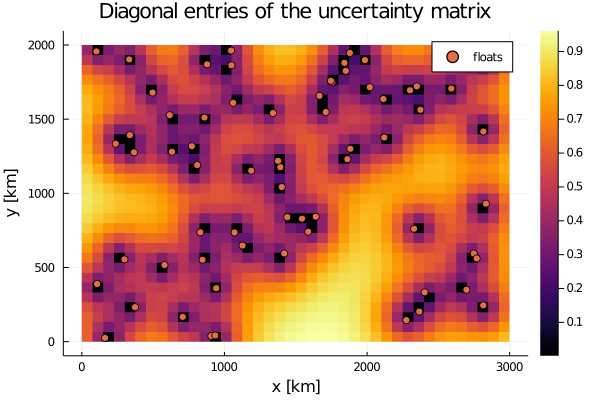

In [10]:
heatmap(
    grid.xticks/km,grid.yticks/km,
    reshape(diag(P_p),grid.ny,grid.nx), 
    xaxis="x [km]", yaxis="y [km]",
)
scatter!(rx/km,ry/km,label="floats")
title!("Diagonal entries of the uncertainty matrix")

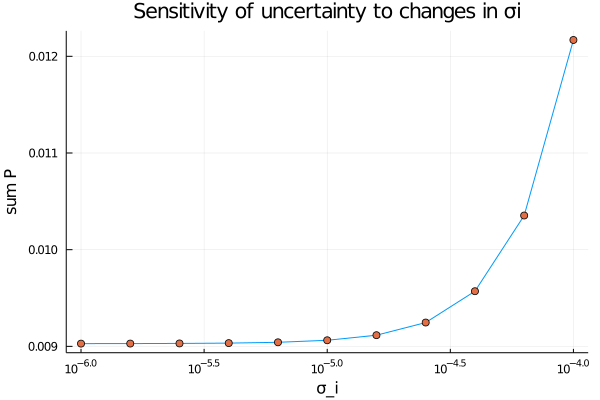

In [11]:
σ_indp_list = [10^i for i in -6:0.2:-4]
Psum = Float64[]
for σ_indp in σ_indp_list
    rnn = (σ_indp*s/km)^2 * I(length(recs))  # [s^2]
    Pi = uncertaintyMatrix(D, rxx, rnn);  # [(s/m)^2]
    push!(Psum, sum(Pi) / prior_variance_scale / N^2)
end

# Plot results
plot(σ_indp_list, Psum, legend = false, ylabel="sum P",xlabel="σ_i", xaxis=:log)
scatter!(σ_indp_list, Psum)
title!("Sensitivity of uncertainty to changes in σi")

# Relative seismic measurements

In [12]:
# Define source location
sx = -100km; sy = physical_dims.y / 2
src = Point(sx, sy)

# receivers-pairs mapping
M_r = receiverPairs(recs, src, max_degrees = 10, max_distance=1000km);
# distance matrix
D_r = distanceMatrix(recs, src, grid);
# relative distance matrix
E_r = relativeDistanceMatrix(M_r,D_r);

### Compute uncertainty

In [13]:
σnn_r = 100m  # uncertainty in position of resurfacing float
σ_indp_r = 10ms  # independent TT noise
rnn_r = Rnn(M_r*slowness, σnn_r, σ_indp_r);  # [s^2]

# uncertainty
P_r = uncertaintyMatrix(E_r, rxx, rnn_r);
sum(P_r) / prior_variance_scale / N^2

0.010995596424445336

In [14]:
1 - sum(P_r) / sum(rxx)

0.8360989140287081

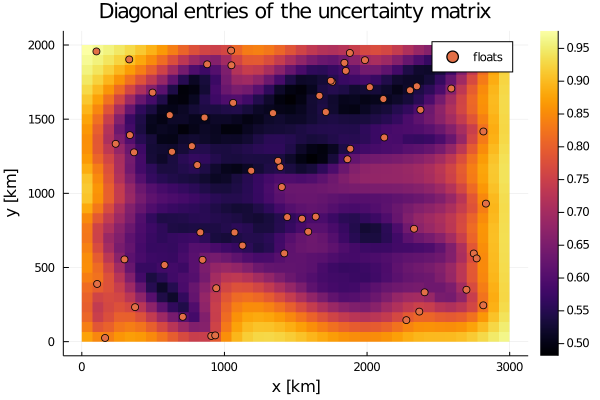

In [15]:
heatmap(
    grid.xticks/km,grid.yticks/km,
    reshape(diag(P_r)/prior_variance_scale,grid.ny,grid.nx), 
    xaxis="x [km]", yaxis="y [km]",
)
scatter!(rx/km,ry/km,label="floats")
title!("Diagonal entries of the uncertainty matrix")

# Combined data

In [16]:
# Design matrix
E_c = [E_r; D];

# data uncertainty
zer = zeros(size(rnn_r)[1], size(rnn_p)[2]);
rnn_c = [rnn_r zer; zer' rnn_p];

P_c = uncertaintyMatrix(E_c, rxx, rnn_c);
sum(P_c) / prior_variance_scale / N^2

0.004218962937978869

In [17]:
1 - sum(P_c) / sum(rxx)

0.9371118600106088

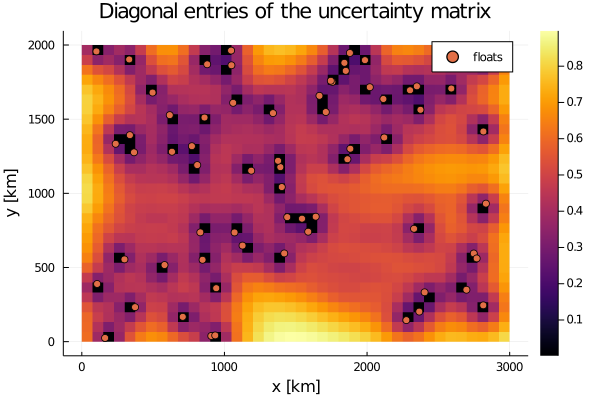

In [18]:
heatmap(
    grid.xticks/km,grid.yticks/km,
    reshape(diag(P_c)/prior_variance_scale,grid.ny,grid.nx), 
    xaxis="x [km]", yaxis="y [km]",
)
scatter!(rx/km,ry/km,label="floats")
title!("Diagonal entries of the uncertainty matrix")